# Elife Paper 
## Figure 6L: Neural Activity


In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import json 
import pickle
from functions import *
import queue
from scipy.integrate import solve_ivp
from env_lite import Environment
from model import NN
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm, colors

In [2]:
# load parameters from json file
params_path = "params_6.json" # yeah we are using the old one again, its good shit
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)
# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 40
ANNEALING = parameters['params']['ANNEALING'] # annealing 
print(ANNEALING)                  
print(f'Random seed is {RANDOM_SEED}')

1
Random seed is 40


In [3]:
# Config
# 1 to load model
# 1 to save model
load = 1
save = 0
model_version = "model_20"  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")


Model 'model_20' loaded successfully!


In [4]:
# Poisson Spike Plotter
def spike_plotter_poisson(rate_array, size_of_time_bin, scaling_factor = 1, rate_max=400, dt = 0.001, state=42):
    time_bins, channels = rate_array.shape
    # dt = 0.02 / time_points_per_rate  # 20ms per coarse bin, divided into fine bins
    scaling_factor = rate_max * 0.02  # 0.02s = 20ms

    spike_raster = np.zeros((time_bins * size_of_time_bin, channels), dtype=int)
    np.random.seed(state)
    for c in range(channels):
        for t in range(time_bins):
            start = t * size_of_time_bin
            end = (t + 1) * size_of_time_bin
            # Compute expected spike count (lambda) for this 20ms window
            rate = squash(rate_array[t, c], p=20, a=0.00) * scaling_factor # rate from 0-1 to 0-8 spikes per timestep
            # np.random.seed(state + c + 2*t + c*t) 
            spike_count = np.random.poisson(rate* rate_max * dt) 
            # print(spike_count, rate)

            # Randomly assign spike_count spikes within the window
            if spike_count > 0:
                spike_times = np.random.choice(size_of_time_bin, size=spike_count, replace=False)
                spike_raster[start + spike_times, c] = 1
    return spike_raster


### A: HVC Neurons

/tmp/ipykernel_1320320/1039801588.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


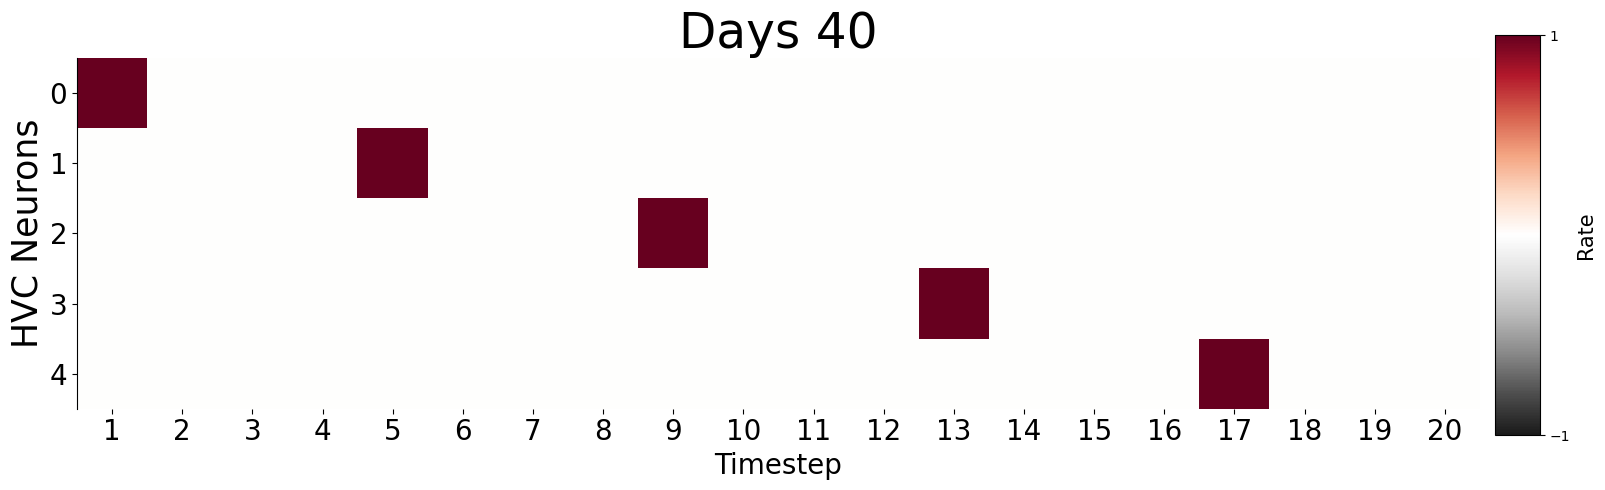

/tmp/ipykernel_1320320/1039801588.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


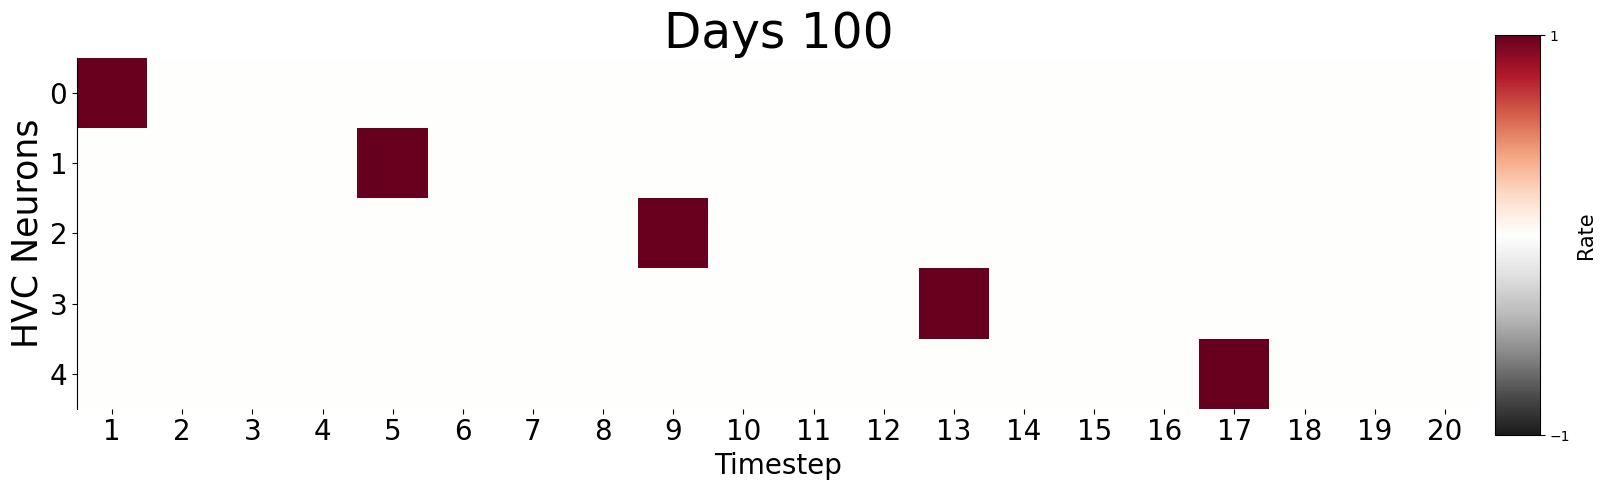

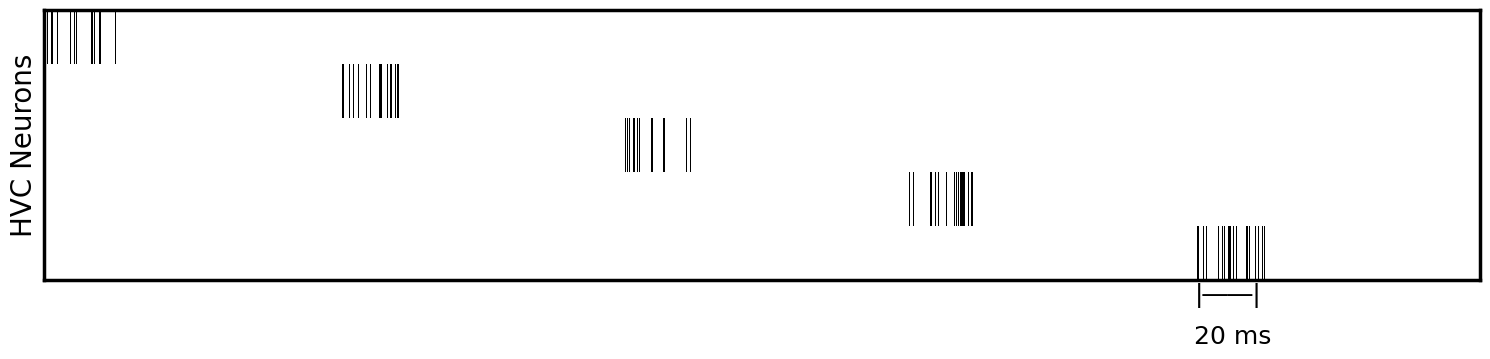

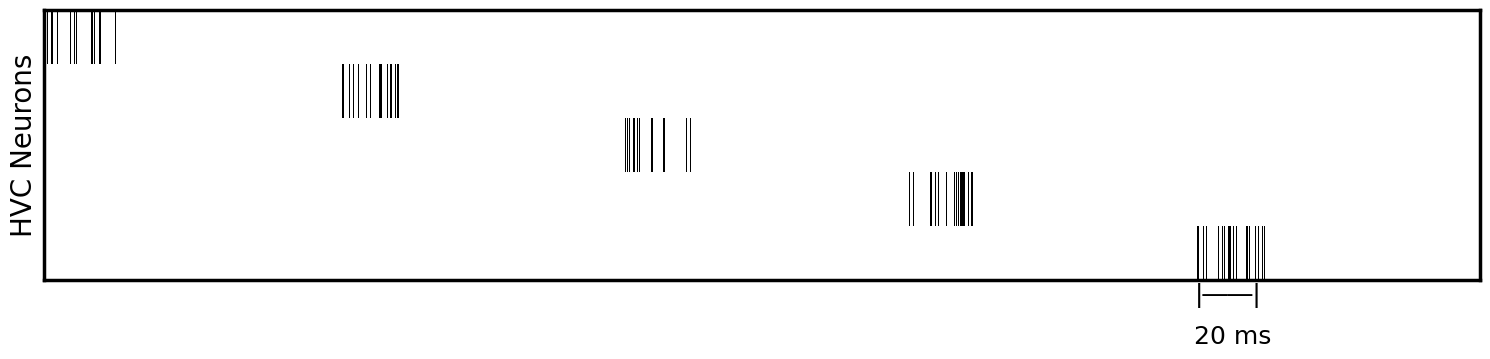

In [5]:
hvc_neurons = 100
hvc_array_all = np.zeros((DAYS, TRIALS, N_SYLL, hvc_neurons))

# Create one-hot vector for each syllable
one_hot = np.eye(hvc_neurons)[np.arange(N_SYLL)]  # shape: (N_SYLL, hvc_neurons)

# Broadcast across days and trials
hvc_array_all[:, :, :, :] = one_hot[np.newaxis, np.newaxis, :, :]

def plot_HVC_motifs_days_rate(obj, day):
    """ Plots the model output over time. """
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
    figure, (ax1) = plt.subplots(1, figsize=(15,5))
    nos_trials_per_day = 1
    nos_neurons = 5
    plot_array = hvc_array_all[day, :nos_trials_per_day,:,:nos_neurons].reshape(nos_trials_per_day*nos_neurons, N_SYLL, order = 'F').T
    # plt.hist(plot_array.flatten(), bins=100, color='black', alpha=0.5)
    # plt.show()
    # plot_array = sigmoid(plot_array, m=1, a=0)
    # spike_raster = bin_and_plot_spikes(sigmoid(plot_array, m=1, a=0), factor=1, bin_size= 6)
    # spike_raster = plot_array
    im1 = ax1.imshow(plot_array.T, aspect='auto', cmap='RdGy_r', interpolation='nearest', vmin = -1, vmax = 1)   
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.00, 0.12, 0.03, 0.8])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Rate', fontsize=15)
    cbar.set_ticks([-1, 1])
    # ax1.vlines(x=-0.5+np.arange(0, nos_trials_per_day*N_SYLL, N_SYLL), ymin =-0.5 , ymax = 7.5,  color='yellow', lw=1, label='Trials') 
    # ax1.set_xlim(0, 10*N_SYLL)
    # ax1.set_xticks(np.arange(0, N_SYLL*nos_trials_per_day*5, N_SYLL*nos_trials_per_day), day + np.arange(0, 5,1), fontsize=15)
    # ax1.set_xlim(0, 10*N_SYLL)
    # ax1.set_xticks()
    # ax1.set_xticks(np.arange(0, N_SYLL*10, N_SYLL), np.arange(0, 10), fontsize=15)
    # ax1.hlines(y = np.arange(nos_neurons*8+1)-0.5, xmin = -0.5, xmax = N_SYLL*1-0.5, color='white', alpha = 0.1)
    # ax1.hlines(y = np.arange(0,nos_neurons*8,8)-0.5, xmin = -0.5, xmax = N_SYLL*1-0.5, color='white', lw=1)      
    # ax1.set_yticks([])  
    # ax1.set_yticks(np.arange(8*nos_neurons), np.tile(np.arange(1, 9), nos_neurons), fontsize=15)
    ax1.set_xticks(np.arange(20), np.arange(1,21)) #, N_SYLL*nos_trials_per_day*spike_bins), day +40 + np.arange(0, 5,1), fontsize=15)
    ax1.tick_params(labelsize=10)
    ax1.set_title(f'Days {day+40}', fontsize=35)
    ax1.tick_params(labelsize=20)
    # ax1.set_title(f'Day {day+40}', fontsize=20)
    ax1.set_ylabel('HVC Neurons', fontsize=25)    
    ax1.set_xlabel('Timestep', fontsize=20)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)  
    ax1.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.show()

def plot_HVC_motifs_on_day_spike(obj, day):
    """ Plots the model output over time. """
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
    figure, (ax1) = plt.subplots(1, figsize=(15,3))
    spike_bins = 1000
    nos_trials_per_day = 1
    nos_neurons = 5

    plot_array = hvc_array_all[day, :nos_trials_per_day,:,:nos_neurons].reshape(nos_trials_per_day*nos_neurons, N_SYLL, order = 'F').T
    # all the elements which are 0, set them to -1 
    plot_array[plot_array == 0] = -1
    # spike_raster = spike_plotter(plot_array, time_points_per_rate=20)
    spike_raster = spike_plotter_poisson(plot_array, size_of_time_bin=100, scaling_factor=1, rate_max=1000)
    im1 = ax1.imshow(spike_raster.T, aspect='auto', cmap='Greys', interpolation='nearest', vmin=0, vmax=1)
    # ax1.vlines(x=-0.5+np.arange(0, nos_trials_per_day*N_SYLL*20, N_SYLL*20), ymin =-0.5 , ymax = 7.5,  color='red', lw=1)  
    # ax1.set_xlim(0, nos_trials_per_day*N_SYLL*20)
    figure.subplots_adjust(right=1.2)
    # cbar_ax = figure.add_axes([1.00, 0.2, 0.03, 0.53])
    # cbar = figure.colorbar(im1, cax=cbar_ax)
    # cbar.set_label('Rate', fontsize=15)
    # cbar.set_ticks([0, 1])
    # ax1.hlines(y = np.arange(nos_neurons*8+1)-0.5, xmin = 0, xmax = N_SYLL*20, color='black', alpha = 0.1)
    # ax1.hlines(y = np.arange(0,nos_neurons*8,8)-0.5, xmin = 0, xmax = N_SYLL*20, color='black', lw=1)
    ax1.set_yticks([])
    ax1.set_xticks([])
    # ax1.set_yticks(np.arange(8*nos_neurons), np.tile(np.arange(1, 9), nos_neurons), fontsize=15)
    # ax1.set_xticks(np.arange(50, N_SYLL*nos_trials_per_day*5*spike_bins, N_SYLL*nos_trials_per_day*spike_bins), day +40 + np.arange(0, 5,1), fontsize=15)
    ax1.tick_params(labelsize=20)
    # ax1.set_title(f'Day {day+40}', fontsize=20)
    ax1.set_ylabel('HVC Neurons', fontsize=20)    
    # ax1.set_xlabel('Time (ms)', fontsize=20)
    for spine in ax1.spines.values():
        spine.set_linewidth(2.5)
        spine.set_color('black')
    # ax1.spines['top'].set_visible(False)
    # ax1.spines['right'].set_visible(False)  
    # ax1.spines['bottom'].set_visible(False)
# === Add timescale bar below axis (xlabel region) ===
    scalebar_len = 20  # ms
    bar_x0 = 0.8       # left position in figure coords (0 = far left, 1 = far right)
    bar_width = 0.05    # width in figure coords
    bar_y = -0.0      # vertical position below the axis

    figure.text(bar_x0, bar_y, '|' + '―'*2 + '|', fontsize=18, ha='left', va='center')
    figure.text(bar_x0 + bar_width/2, bar_y - 0.1, f'{scalebar_len} ms',
                ha='center', va='top', fontsize=18)
    plt.tight_layout()
    plt.show()


plot_HVC_motifs_days_rate(obj,0)
plot_HVC_motifs_days_rate(obj, 60) 

plot_HVC_motifs_on_day_spike(obj,0)
plot_HVC_motifs_on_day_spike(obj,60)

### B: RA neurons

/tmp/ipykernel_1320320/2175123734.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


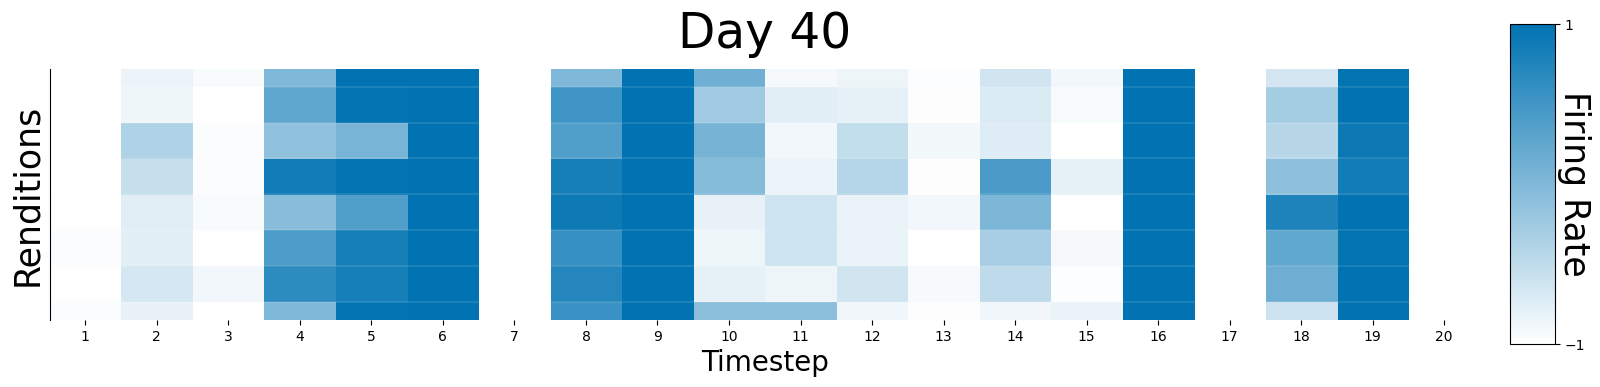

/tmp/ipykernel_1320320/2175123734.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


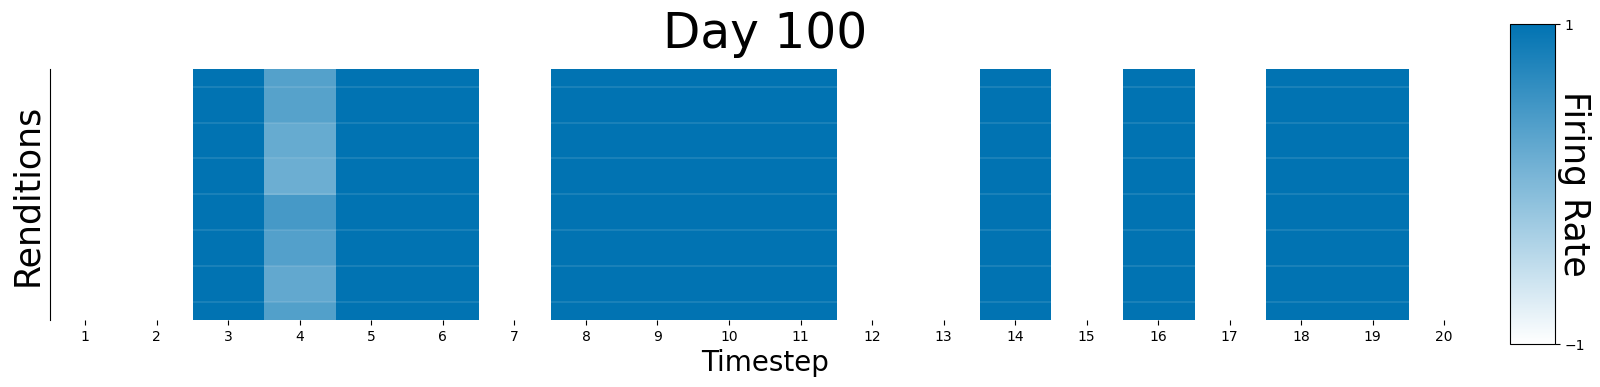

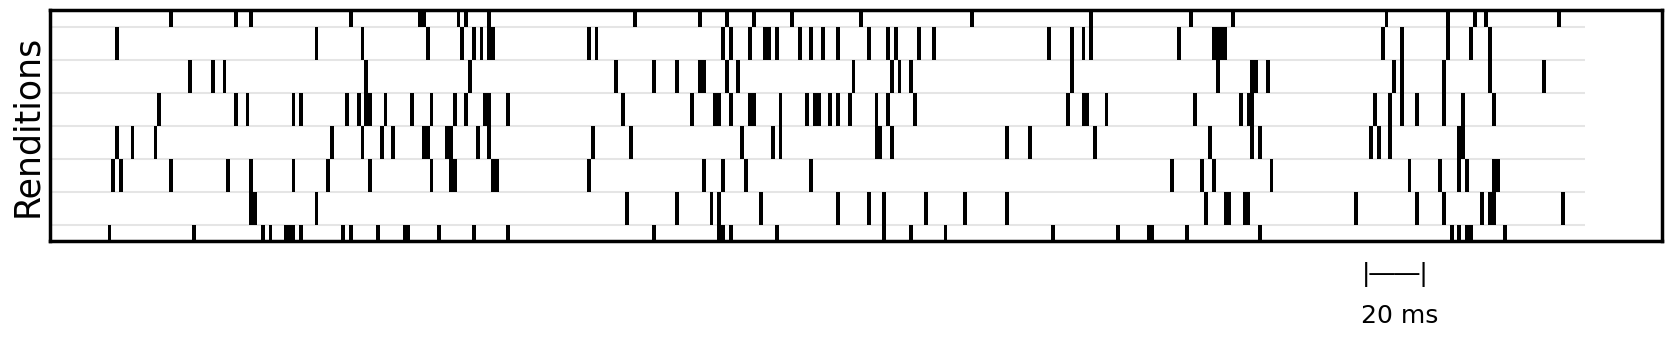

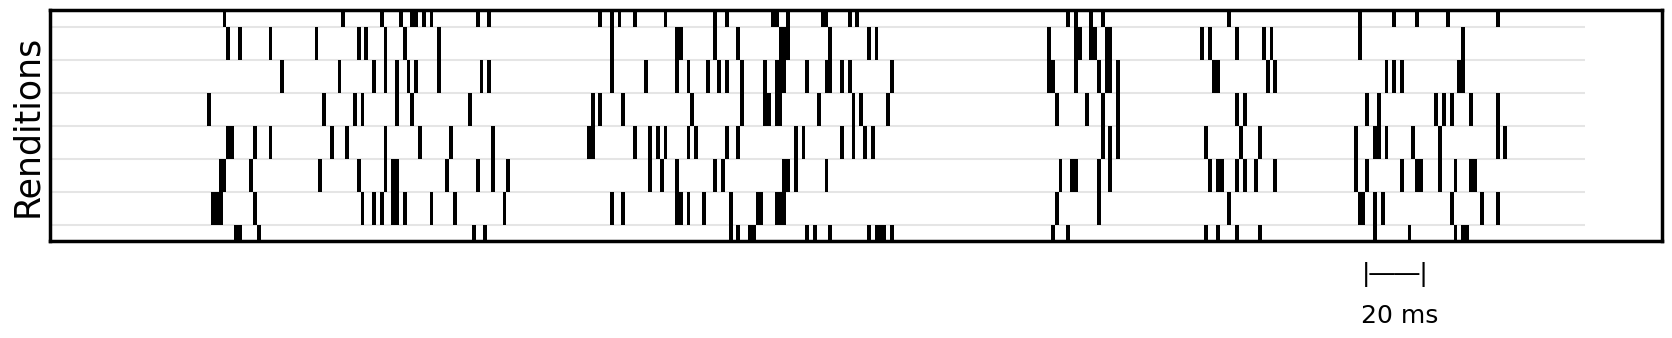

In [6]:


def plot_HL_motifs_days_rate(obj, day):
    """ Plots the model output over time. """
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
    figure, (ax1) = plt.subplots(1, figsize=(15,4))

    cm = LinearSegmentedColormap.from_list('white_to_black', ['white', color_cortical])
    nos_trials_per_day = 8
    nos_neurons = 2
    plot_array = obj.ra_all[day, :nos_trials_per_day, :, :nos_neurons].reshape(nos_trials_per_day*nos_neurons, N_SYLL, order = 'F').T
    # plt.hist(plot_array.flatten(), bins=100, color='black', alpha=0.5)
    # plt.show()
    # plot_array = sigmoid(plot_array, m=1, a=0)
    # spike_raster = bin_and_plot_spikes(sigmoid(plot_array, m=1, a=0), factor=1, bin_size= 6)
    # spike_raster = plot_array
    im1 = ax1.imshow(plot_array.T, aspect='auto', cmap=cm, interpolation='nearest', vmin = -1, vmax = 1)   
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.01, 0.12, 0.03, 0.8])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Firing Rate', fontsize=25, rotation = 270)
    cbar.set_ticks([-1, 1])
    # ax1.vlines(x=-0.5+np.arange(0, nos_trials_per_day*N_SYLL, N_SYLL), ymin =-0.5 , ymax = 7.5,  color='yellow', lw=1, label='Trials') 
    # ax1.set_xlim(0, 10*N_SYLL)
    # ax1.set_xticks(np.arange(0, N_SYLL*nos_trials_per_day*5, N_SYLL*nos_trials_per_day), day + np.arange(0, 5,1), fontsize=15)
    # ax1.set_xlim(0, 10*N_SYLL)
    # ax1.set_xticks()
    # ax1.set_xticks(np.arange(0, N_SYLL*10, N_SYLL), np.arange(0, 10), fontsize=15)
    ax1.hlines(y = np.arange(nos_neurons*8+1)-0.5, xmin = -0.5, xmax = N_SYLL*1-0.5, color='white', alpha = 0.1)
    ax1.hlines(y = np.arange(0,nos_neurons*8,8)-0.5, xmin = -0.5, xmax = N_SYLL*1-0.5, color='white', lw=1)      
    ax1.set_yticks([])  
    ax1.set_ylim(0, 7)
    # ax1.set_yticks(np.arange(8*nos_neurons), np.tile(np.arange(1, 9), nos_neurons), fontsize=15)
    ax1.set_xticks(np.arange(20), np.arange(1,21)) #, N_SYLL*nos_trials_per_day*spike_bins), day +40 + np.arange(0, 5,1), fontsize=15)
    ax1.tick_params(labelsize=10)
    ax1.set_title(f'Day {day+40}', fontsize=35, y = 1.05)
    ax1.set_ylabel('Renditions', fontsize=25)    
    ax1.set_xlabel('Timestep', fontsize=20)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)  
    ax1.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.show()

def plot_HL_motifs_on_day_spike(obj, day):
    """ Plots the model output over time. """
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  
    figure, (ax1) = plt.subplots(1, figsize=(15,3))
    spike_bins = 1000
    nos_trials_per_day = 8
    nos_neurons = 2
    plot_array = obj.ra_all[day, :nos_trials_per_day, :, :nos_neurons].reshape(nos_trials_per_day*nos_neurons, N_SYLL, order = 'F').T
    # spike_raster = spike_plotter(plot_array, time_points_per_rate=20)
    spike_raster = spike_plotter_poisson(plot_array, size_of_time_bin=20, scaling_factor=1)
    im1 = ax1.imshow(spike_raster.T, aspect='auto', cmap='Greys', interpolation='nearest', vmin=0, vmax=1)
    # ax1.vlines(x=-0.5+np.arange(0, nos_trials_per_day*N_SYLL*20, N_SYLL*20), ymin =-0.5 , ymax = 7.5,  color='red', lw=1)  
    # ax1.set_xlim(0, nos_trials_per_day*N_SYLL*20)
    figure.subplots_adjust(right=1.2)
    # cbar_ax = figure.add_axes([1.00, 0.2, 0.03, 0.53])
    # cbar = figure.colorbar(im1, cax=cbar_ax)
    # cbar.set_label('Rate', fontsize=15)
    # cbar.set_ticks([0, 1])
    ax1.hlines(y = np.arange(nos_neurons*8+1)-0.5, xmin = 0, xmax = N_SYLL*20, color='black', alpha = 0.1)
    ax1.hlines(y = np.arange(0,nos_neurons*8,8)-0.5, xmin = 0, xmax = N_SYLL*20, color='black', lw=1)
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_ylim(0, 7)
    # ax1.set_yticks(np.arange(8*nos_neurons), np.tile(np.arange(1, 9), nos_neurons), fontsize=15)
    # ax1.set_xticks(np.arange(50, N_SYLL*nos_trials_per_day*5*spike_bins, N_SYLL*nos_trials_per_day*spike_bins), day +40 + np.arange(0, 5,1), fontsize=15)
    ax1.tick_params(labelsize=20)
    # ax1.set_title(f'Day {day+40}', fontsize=20)
    ax1.set_ylabel('Renditions', fontsize=25)    
    # ax1.set_xlabel('Time (ms)', fontsize=20)
    for spine in ax1.spines.values():
        spine.set_linewidth(2.5)
        spine.set_color('black')

# === Add timescale bar below axis (xlabel region) ===
    scalebar_len = 20  # ms
    bar_x0 = 1       # left position in figure coords (0 = far left, 1 = far right)
    bar_width = 0.05    # width in figure coords
    bar_y = -0.0      # vertical position below the axis

    figure.text(bar_x0, bar_y, '|' + '―'*2 + '|', fontsize=18, ha='left', va='center')
    figure.text(bar_x0 + bar_width/2, bar_y - 0.1, f'{scalebar_len} ms',
                ha='center', va='top', fontsize=18)



plot_HL_motifs_days_rate(obj,0)
plot_HL_motifs_days_rate(obj, 60) 

plot_HL_motifs_on_day_spike(obj,0)
plot_HL_motifs_on_day_spike(obj,60)

### C: BG neurons

/tmp/ipykernel_1320320/1692908207.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


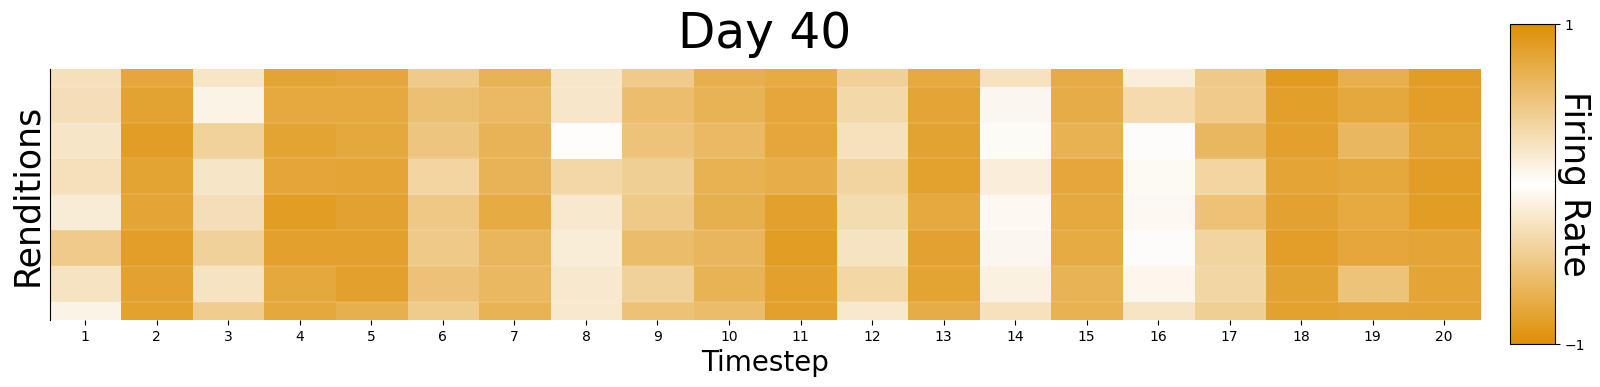

/tmp/ipykernel_1320320/1692908207.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


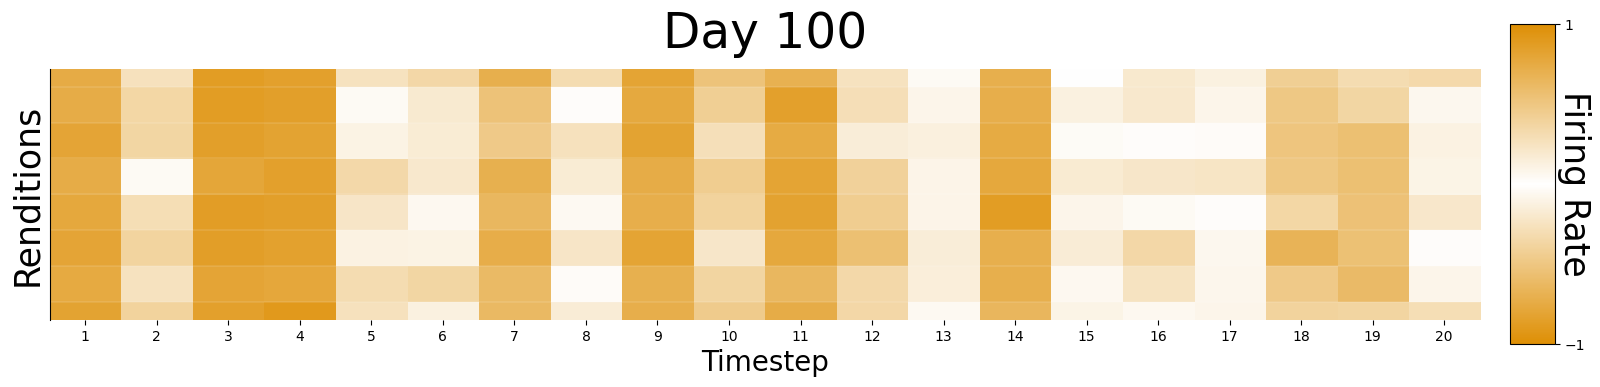

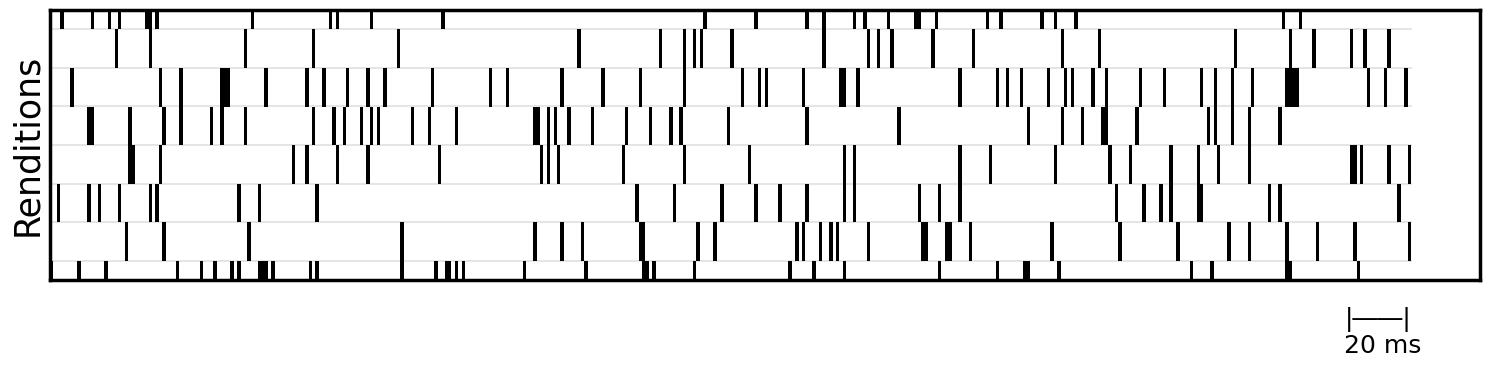

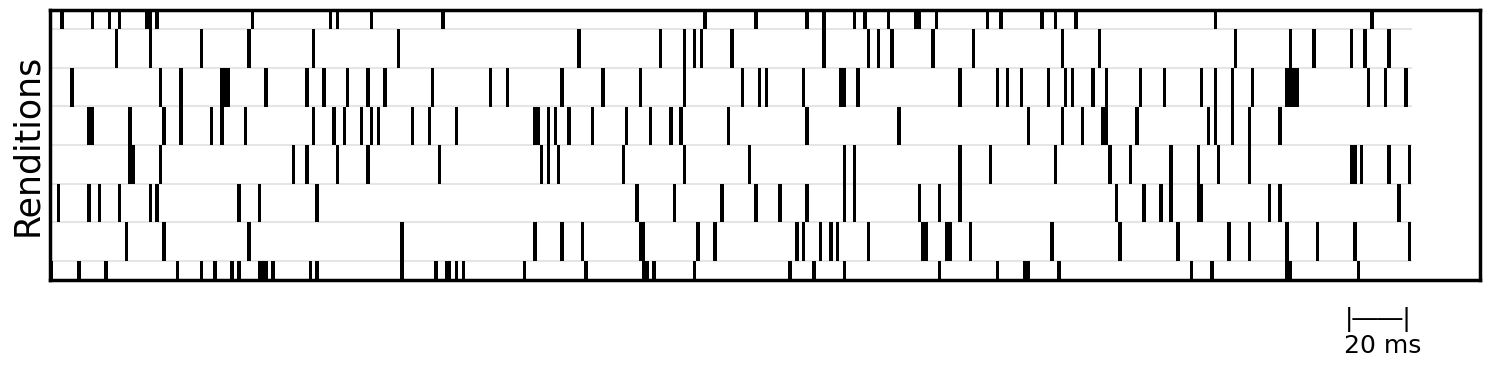

In [7]:
def plot_RL_motifs_days_rate(obj, day):
    """ Plots the BG model output over time (rate heatmap). """
    figure, ax1 = plt.subplots(1, figsize=(15,4))

    cm = colors.LinearSegmentedColormap.from_list('my_cmap', [color_bg,'white', color_bg], N=256)
    nos_trials_per_day = 8
    nos_neurons = 2

    plot_array = obj.bg_all[day, :nos_trials_per_day, :, :nos_neurons] \
                    .reshape(nos_trials_per_day*nos_neurons, N_SYLL, order='F').T

    im1 = ax1.imshow(plot_array.T, aspect='auto', cmap=cm,
                     interpolation='nearest', vmin=-1, vmax=1)

    # external colorbar
    figure.subplots_adjust(right=1.2)
    cbar_ax = figure.add_axes([1.01, 0.12, 0.03, 0.8])
    cbar = figure.colorbar(im1, cax=cbar_ax)
    cbar.set_label('Firing Rate', fontsize=25, rotation=270)
    cbar.set_ticks([-1, 1])

    # horizontal separators
    ax1.hlines(y=np.arange(nos_neurons*8+1)-0.5, xmin=-0.5, xmax=N_SYLL*1-0.5,
               color='white', alpha=0.1)
    ax1.hlines(y=np.arange(0, nos_neurons*8, 8)-0.5, xmin=-0.5, xmax=N_SYLL*1-0.5,
               color='white', lw=1)

    ax1.set_yticks([])
    ax1.set_ylim(0, 7)

    # xticks
    ax1.set_xticks(np.arange(20), np.arange(1, 21))
    ax1.tick_params(labelsize=10)

    # labels & title
    ax1.set_title(f'Day {day+40}', fontsize=35, y=1.05)
    ax1.set_ylabel('Renditions', fontsize=25)
    ax1.set_xlabel('Timestep', fontsize=20)

    # spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    plt.tight_layout()
    plt.show()


def plot_RL_motifs_on_day_spike(obj, day):
    """ Plots the BG model output over time (spike raster). """
    figure, ax1 = plt.subplots(1, figsize=(15,3))

    nos_trials_per_day = 8
    nos_neurons = 2
    plot_array = obj.bg_all[day, :nos_trials_per_day, :, :nos_neurons] \
                    .reshape(nos_trials_per_day*nos_neurons, N_SYLL, order='F').T

    spike_raster = spike_plotter_poisson(plot_array, size_of_time_bin=20, scaling_factor=1)

    im1 = ax1.imshow(spike_raster.T, aspect='auto', cmap='Greys',
                     interpolation='nearest', vmin=0, vmax=1)

    # horizontal separators
    ax1.hlines(y=np.arange(nos_neurons*8+1)-0.5, xmin=0, xmax=N_SYLL*20,
               color='black', alpha=0.1)
    ax1.hlines(y=np.arange(0, nos_neurons*8, 8)-0.5, xmin=0, xmax=N_SYLL*20,
               color='black', lw=1)

    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.set_ylim(0, 7)

    ax1.tick_params(labelsize=20)

    # labels & title
    ax1.set_ylabel('Renditions', fontsize=25)

    # make spines bold
    for spine in ax1.spines.values():
        spine.set_linewidth(2.5)
        spine.set_color('black')

    # === Add timescale bar below axis (xlabel region) ===
    scalebar_len = 20  # ms
    bar_x0 = 0.9       # left position in figure coords (center-ish)
    bar_width = 0.05    # width in figure coords
    bar_y = -0.08       # vertical position below axis

    figure.text(bar_x0, bar_y, '|' + '―'*2 + '|', fontsize=18,
                ha='left', va='center')
    figure.text(bar_x0 + bar_width/2, bar_y - 0.05,
                f'{scalebar_len} ms', ha='center', va='top', fontsize=18)

    plt.tight_layout()
    plt.show()



plot_RL_motifs_days_rate(obj,0)
plot_RL_motifs_days_rate(obj, 60) 

plot_RL_motifs_on_day_spike(obj,0)
plot_RL_motifs_on_day_spike(obj,60)